In [19]:
#the dataset has imbalance class distribution. So trying out over and down sampling. 

In [1]:
#implemented ideas from https://towardsdatascience.com/yet-another-twitter-sentiment-analysis-part-1-tackling-class-imbalance-4d7a7f717d44

In [52]:
import pandas as pd
import numpy as np
import json
import re
import string
import nltk
import spacy
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from textblob import TextBlob
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


In [3]:
nltk.download('words')
eng_words=set(nltk.corpus.words.words())
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=stopwords.words('english')
stopwords.extend(['book','story','read','reading','really','one'])

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
filepath='E:/Ramya/brushUps/Basics/ML using sklearn/Projects/Sentiment_analysis/data/goodreads_reviews_children.json'
with open(filepath) as f:
    lines=f.read().splitlines()

In [6]:
data_inter=pd.DataFrame(lines)
data_inter.columns=['json_element']

In [7]:
data_inter['json_element'].apply(json.loads)

0         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
1         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
2         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
3         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
4         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
                                ...                        
734635    {'user_id': '480ac8b4df39533a6c7fe6ae109aa56a'...
734636    {'user_id': 'afcd096765a8c354be0706ab1324999b'...
734637    {'user_id': 'd94c83867337514c94738b57a1d19677'...
734638    {'user_id': '48a10d546ba07520ce194dc18e687be4'...
734639    {'user_id': 'da6f9516279ed671027308abd21318bd'...
Name: json_element, Length: 734640, dtype: object

In [8]:
data=pd.json_normalize(data_inter['json_element'].apply(json.loads))

In [9]:
reviews_data=data[['book_id','rating','review_text']]

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [16]:
def reviewsTextCleaning(review):
    #expanding words
    review=' '.join([contraction_mapping[word] if word in contraction_mapping.keys() else word for word in review.split()])
    #removing @mentions
    review=re.sub(r'@[A-Za-z0-9]+',' ',review)
    review=review.lower()
    review=review.strip()
    review=review.replace('\n','')
    review=review.replace('\t','')
    #converting apostrophes to single quote
    review=review.replace("’", "'")
    #removing punctuations
    review=review.translate(str.maketrans('','',string.punctuation))
    #removinf digits
    review=re.sub(r'\d+','',review)
    #removing urls
    review=re.sub(r'^https?:\/\/.*[\r\n]*','',review)
    #removing tags
    remove_tags=re.compile('<.*?>')
    review=re.sub(remove_tags,'',review) 
    #ignoring gibberish words
    review=' '.join(w for w in nltk.wordpunct_tokenize(review) if w.lower() in eng_words or not w.isalpha())
    #lemmatization
    nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])
    review=' '.join([token.lemma_ for token in nlp(review)])
    # removing repeated characters 
    review=re.sub(r'(.)\1+', r'\1\1', review)

    return review                                                                                                                                                                                                                                                                                                                                                   

In [17]:
reviews_data['review_text']=reviews_data['review_text'].apply(reviewsTextCleaning)

<ipython-input-17-8f1a8d71108e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['review_text']=reviews_data['review_text'].apply(reviewsTextCleaning)


In [18]:
reviews_data['review_text'].head

<bound method NDFrame.head of 0                                fun sequel to the original
1         one of my favorite to read to my year old to h...
2         one of the good and most imaginative I have ev...
3         my daughter be love this in the s and one of t...
4                            a friend send I this hilarious
                                ...                        
734635    do not give a satisfying end to the series a d...
734636    my mother give I this book as a gift it be ado...
734637    if I be a middle grade I would give this anyho...
734638    I have a limited selection of childhood I stil...
734639    I collect write and by I love his and this be ...
Name: review_text, Length: 734640, dtype: object>

In [21]:
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

In [22]:
def polarityInference(score):
    if score >0:
        return 1
    elif score ==0:
        return 0
    else:
        return -1

In [23]:
reviews_data['polarity_Score']=reviews_data['review_text'].apply(getPolarity)
reviews_data['sentiment']=reviews_data['polarity_Score'].apply(polarityInference)

<ipython-input-23-9b67ca57053b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['polarity_Score']=reviews_data['review_text'].apply(getPolarity)
<ipython-input-23-9b67ca57053b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['sentiment']=reviews_data['polarity_Score'].apply(polarityInference)


In [24]:
sentiment_data=reviews_data[['review_text','sentiment']]

In [27]:
class_dist=sentiment_data['sentiment'].value_counts()

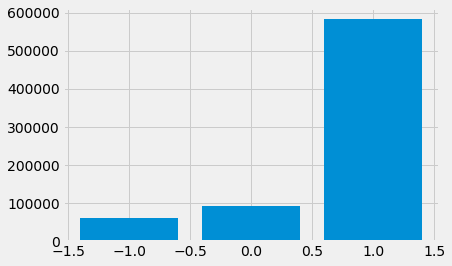

In [29]:
plt.style.use('fivethirtyeight')
plt.bar(class_dist.index,class_dist.values)
plt.show()

In [35]:
tfidf=TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,max_df=0.8,min_df=0.2)
tfidf_matrix=tfidf.fit_transform(sentiment_data['review_text'])
tfidf_matrix.shape

(734640, 3)

In [66]:
def data_split(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    return X_train,X_test,y_train,y_test

In [67]:
def classification(X_train,X_test,y_train,y_test):
    clf=LogisticRegression()
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(classification_report(y_test,y_pred))


In [68]:
# Classification of imbalanced class

X_train,X_test,y_train,y_test=data_split(tfidf_matrix,np.array(sentiment_data['sentiment']).reshape(-1,1))
classification(X_train,X_test,y_train,y_test)

C:\Users\ramya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     12174
           0       0.00      0.00      0.00     18346
           1       0.79      1.00      0.88    116408

    accuracy                           0.79    146928
   macro avg       0.26      0.33      0.29    146928
weighted avg       0.63      0.79      0.70    146928



C:\Users\ramya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ramya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ramya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [49]:
# going to try over sampling. SMOTE and Random Sampler

In [56]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
smk=SMOTE(random_state=42)
X_newset,y_newset=smk.fit_resample(tfidf_matrix,np.array(sentiment_data['sentiment']).reshape(-1,1))

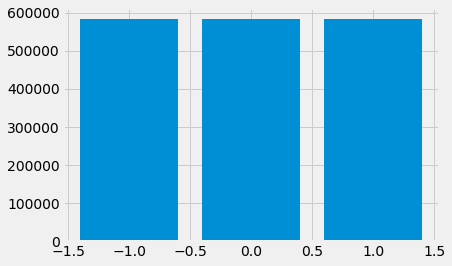

In [64]:
groups=[-1,0,1]
vals=[np.count_nonzero(y_newset==-group)for group in groups]
plt.bar(groups,vals)
plt.show()

In [70]:
# Classification of balanced class from SMOTE

X_train,X_test,y_train,y_test=data_split(X_newset,y_newset)
classification(X_train,X_test,y_train,y_test)

              precision    recall  f1-score   support

          -1       0.36      0.09      0.14    116699
           0       0.56      0.77      0.65    116947
           1       0.49      0.68      0.57    115976

    accuracy                           0.51    349622
   macro avg       0.47      0.51      0.45    349622
weighted avg       0.47      0.51      0.45    349622

